## Analysis of Qiskit results

#### Imports

In [ ]:
import numpy as np
import json
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

#### Compute the circuit

In [ ]:
# --------------------------
# Load one-body data
# --------------------------
data_onebody = np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys = data_onebody['keys']
values = data_onebody['values']
n_qubits = 3

t_onebody = {}
for a, key in enumerate(keys):
    i, j = key
    t_onebody[(i, j)] = values[a]

# Build target Hamiltonian
from src.qiskit_utils import get_hamiltonian
hamiltonian_q = get_hamiltonian(t_onebody, n_qubits)

# Driver Hamiltonian
coupling_term = -18.4321
Z_tuples = [("Z", [0], -0.5*coupling_term)]
I_tuples = [('I', [0], 0.5*coupling_term)]
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples, *I_tuples], num_qubits=n_qubits)

# --------------------------
# Time evolution circuit
# --------------------------
time_steps = 10
tf = 1
time = np.linspace(0, tf, time_steps)
dt = tf / time_steps
driver = 1 - time/tf

circuit_time_evolution = QuantumCircuit(hamiltonian_q.num_qubits)
circuit_time_evolution.x([0])  # initial state

for n, t in enumerate(time):
    hamiltonian_t = (driver[n])*hamiltonian_driver + (1-driver[n])*hamiltonian_q
    exp_H_t = PauliEvolutionGate(hamiltonian_t, time=dt, synthesis=SuzukiTrotter(order=1))
    circuit_time_evolution.append(exp_H_t, range(hamiltonian_q.num_qubits))


# --------------------------
# Measurement circuits
# --------------------------
creg = ClassicalRegister(n_qubits)

# Z basis
circuit_z = circuit_time_evolution.copy()
circuit_z.add_register(creg)
circuit_z.measure(range(n_qubits), range(n_qubits))

# X basis
circuit_x = circuit_time_evolution.copy()
circuit_x.add_register(creg)
circuit_x.h(range(n_qubits))
circuit_x.measure(range(n_qubits), range(n_qubits))

# Y basis
circuit_y = circuit_time_evolution.copy()
circuit_y.add_register(creg)
circuit_y.sdg(range(n_qubits))
circuit_y.h(range(n_qubits))
circuit_y.measure(range(n_qubits), range(n_qubits))

#### Load the results

In [1]:
import json

# Load hardware histograms
with open("histogram_z.json", "r") as f:
    hist_z = json.load(f)

with open("histogram_x.json", "r") as f:
    hist_x = json.load(f)

with open("histogram_y.json", "r") as f:
    hist_y = json.load(f)

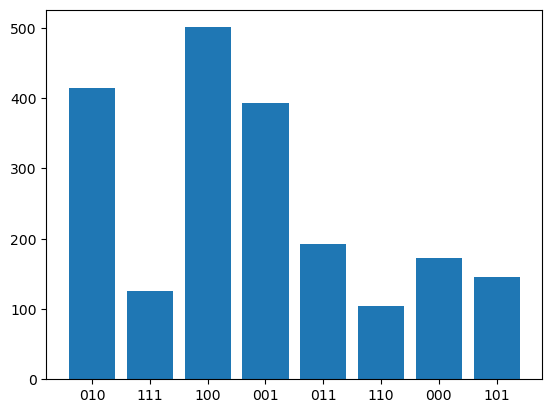

In [2]:
import matplotlib.pyplot as plt

plt.bar(hist_z.keys(), hist_z.values())
plt.show()